# Generative Adversarial Networks

In [1]:
arr = ['code', 'test']
arr[0].title()

'Code'

In [2]:
#!pip install d2l
#!pip install gym 

In [3]:
import tensorflow as tf
import d2l_tensorflow as d2l

## Building D2l from Source gave me some error

- I had to fetch the d2l/tensorflow.py file from the github repo and put it in the same directory as the noteboo
- i renamed it to d2l_tensorflow.py for convenience
  
> error msg

```bash
 udio.microsoft.com/visual-cpp-build-tools/
    [end of output]

note: This error originates from a subprocess, and is likely not a problem with pip.
ERROR: Failed building wheel for pandas
Failed to build pandas
ERROR: Could not build wheels for pandas, which is required to install pyproject.toml-based projects
```


## Generate Some "Real" Data

Since this is going to be the world's lamest example, we simply generate data drawn from a Gaussian.


In [4]:
X = tf.random.normal((1000, 2), 0.0, 1)

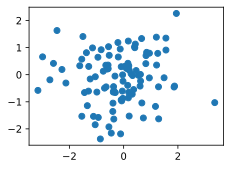

In [5]:
d2l.set_figsize()
d2l.plt.scatter(X[:100, (0)].numpy(), X[:100, (1)].numpy());

In [6]:
A = tf.constant([[1, 2], [-0.1, 0.5]])
b = tf.constant([1, 2], tf.float32)
data = tf.matmul(X, A) + b

Let us see what we got. This should be a Gaussian shifted in some rather arbitrary way with mean $b$ and covariance matrix $A^TA$.


The covariance matrix is
[[1.01 1.95]
 [1.95 4.25]]


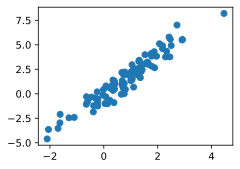

In [7]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, (0)].numpy(), data[:100, (1)].numpy());
print(f'The covariance matrix is\n{tf.matmul(A, A, transpose_a=True)}')

In [8]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

## Generator

Our generator network will be the simplest network possible - a single layer linear model. This is since we will be driving that linear network with a Gaussian data generator. Hence, it literally only needs to learn the parameters to fake things perfectly.


In [9]:
net_G = tf.keras.layers.Dense(2)

## Discriminator

For the discriminator we will be a bit more discriminating: we will use an MLP with 3 layers to make things a bit more interesting.


In [10]:
net_D = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, activation="tanh", input_shape=(2,)),
    tf.keras.layers.Dense(3, activation="tanh"),
    tf.keras.layers.Dense(1)
])

## Training

First we define a function to update the discriminator.


## Phase 1
Train the discriminator + FREEZE generator

1. Input: 
    - A batch of data real images + generator fake images
    - Labels: 1 for real images, 0 for fake images, 
	
2. Train discriminator on input for k steps, using the binary cross-entropy loss.

3. FREEZE --> Backpropagation only update the weights of the discriminator.

In [11]:
def update_D(X, Z, net_D, net_G, loss, optimizer_D):
    """Update discriminator."""

    batch_size = X.shape[0]
    
    ### Labels
    ones = tf.ones((batch_size,)) # Labels corresponding to real data
    zeros = tf.zeros((batch_size,)) # Labels corresponding to fake data
    
    # Do not need to compute gradient for `net_G`, so it's outside GradientTape
    fake_X = net_G(Z)
    
    with tf.GradientTape() as tape:
        real_Y = net_D(X) # Real data
        fake_Y = net_D(fake_X) # Fake data
        
        # We multiply the loss by batch_size to match tensorflow's BCEWithLogitsLoss
        loss_D = (loss(ones, tf.squeeze(real_Y)) + loss(
            zeros, tf.squeeze(fake_Y))) * batch_size / 2
        
    #### Update discriminator weights
    grads_D = tape.gradient(loss_D, net_D.trainable_variables)
    
    optimizer_D.apply_gradients(zip(grads_D, net_D.trainable_variables))
    
    return loss_D

The generator is updated similarly. Here we reuse the cross-entropy loss but change the label of the fake data from $0$ to $1$.


## Phase 2
Train the generator + FREEZE discriminator: 

1. Generator --> Get batch of fake images 

2. Discriminator --> images are fake or real?
    - Do not add real images in the batch, and all the labels are set to 1 (real)
    - We want the generator to produce images that the discriminator will (wrongly) believe to be real!

3. FREEZE --> Backpropagation only updates the weights of the generator.

In [12]:

def update_G(Z, net_D, net_G, loss, optimizer_G):
    """Update generator."""
    
    batch_size = Z.shape[0]
    ## Labels all 1
    ones = tf.ones((batch_size,))
    
    with tf.GradientTape() as tape:
       
        # Fake images: We could reuse `fake_X` from `update_D` to save computation
        fake_X = net_G(Z)
        # Recomputing `fake_Y` is needed since `net_D` is changed
        fake_Y = net_D(fake_X)
        # We multiply the loss by batch_size to match TF's BCEWithLogits loss
        loss_G = loss(ones, tf.squeeze(fake_Y)) * batch_size
        
    ## Update generator weights
    grads_G = tape.gradient(loss_G, net_G.trainable_variables)
    optimizer_G.apply_gradients(zip(grads_G, net_G.trainable_variables))
    
    return loss_G

Both the discriminator and the generator performs a binary logistic regression with the cross-entropy loss. We use Adam to smooth the training process. In each iteration, we first update the discriminator and then the generator. We visualize both losses and generated examples.


In [13]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
    
    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
        
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
        
    optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr_D)
    optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr_G)
    
    animator = d2l.Animator(
        xlabel="epoch", ylabel="loss", xlim=[1, num_epochs], nrows=2,
        figsize=(5, 5), legend=["discriminator", "generator"])
    animator.fig.subplots_adjust(hspace=0.3)
    
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            
            ### Noise input
            Z = tf.random.normal(
                mean=0, stddev=1, shape=(batch_size, latent_dim))
            
            ### Training
            metric.add(update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)
        # Visualize generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(100, latent_dim))
        fake_X = net_G(Z)
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(["real", "generated"])

        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))

    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

Now we specify the hyperparameters to fit the Gaussian distribution.


loss_D 0.693, loss_G 0.693, 240.6 examples/sec


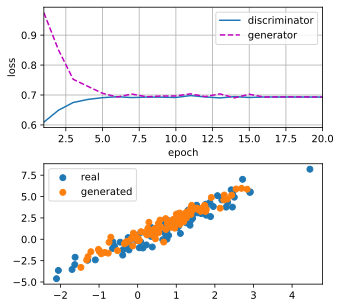

In [14]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20

train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data[:100].numpy())

## Summary

* Generative adversarial networks (GANs) composes of two deep networks, the generator and the discriminator.
* The generator generates the image as much closer to the true image as possible to fool the discriminator, via maximizing the cross-entropy loss, *i.e.*, $\max \log(D(\mathbf{x'}))$.
* The discriminator tries to distinguish the generated images from the true images, via minimizing the cross-entropy loss, *i.e.*, $\min - y \log D(\mathbf{x}) - (1-y)\log(1-D(\mathbf{x}))$.